In [1]:
import pandas as pd
import datetime as dt
import json

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_colwidth', -1)
%matplotlib inline
plt.style.use('fivethirtyeight')

In [14]:
df = pd.read_csv('src/data/joined_and_tonnage.csv')

print(df[df.boro_cd == 101].groupby('year').REFUSETONSCOLLECTED.sum().reset_index())
print('\n')
print(df[df.boro_cd == 101].groupby('year').total_recycled.sum().reset_index())

year  REFUSETONSCOLLECTED
0   2009  13451.8            
1   2010  13993.5            
2   2011  14657.0            
3   2012  15018.9            
4   2013  15349.8            
5   2014  15640.1            
6   2015  15670.0            
7   2016  15792.0            
8   2017  16273.0            
9   2018  16485.5            
10  2019  14126.4            


    year  total_recycled
0   2009  7071.0        
1   2010  6946.9        
2   2011  6904.8        
3   2012  6318.3        
4   2013  6373.6        
5   2014  6630.1        
6   2015  6945.9        
7   2016  7196.4        
8   2017  7142.9        
9   2018  7531.4        
10  2019  6719.5        


In [49]:
## Slimming down the data as much as possible
## We still want all the demographic data we can get

df = pd.read_csv('src/data/joined_and_tonnage.csv', usecols=['boro_cd', 'BOROUGH', 'year', 'poverty_rate', 'REFUSETONSCOLLECTED', 'total_recycled', 'pct_foreign_born', 'fp_100_mhhi'])

indicators = pd.read_csv('src/data/Bronx-2-indicators.csv', usecols=['borocd' ,'poverty_rate']).rename(columns={'borocd':'boro_cd'})

df2 = df.groupby(['year', 'boro_cd']).total_recycled.sum().reset_index()
print(df.keys())
df2['total_refuse'] = df.groupby(['year', 'boro_cd']).REFUSETONSCOLLECTED.sum().reset_index().REFUSETONSCOLLECTED
df2['total_waste'] = df2.total_refuse + df2.total_recycled
df2['pct_recycled_annum'] = df2.total_recycled / df2.total_waste * 100

## grabbing the 2009 mean
mean_2009 =  df2[df2.year == 2009].groupby('boro_cd').pct_recycled_annum.mean().reset_index().rename(columns={'pct_recycled_annum':'pct_recycled_2009'})

merged = df2.merge(mean_2009, on='boro_cd')

merged['pct_change'] = (merged.pct_recycled_annum / merged.pct_recycled_2009 - 1) * 100
merged['pct_point_change'] = merged.pct_recycled_annum - merged.pct_recycled_2009

final = merged.merge(indicators, on='boro_cd')
final[final.year > 2009]
final['year'] = pd.to_datetime(final.year, format='%Y')

final.to_csv('src/data/racing_bar_chart.csv', index=False)

Index(['boro_cd', 'fp_100_mhhi', 'pct_foreign_born', 'poverty_rate', 'BOROUGH',
       'REFUSETONSCOLLECTED', 'year', 'total_recycled'],
      dtype='object')


## Monthly tonnage from NYC Open Data
- data is by community district
- dates back consistently to 2004-ish, but we're focusing on the last decade
- not using 2019 because the year isn't over!

In [64]:
df = pd.read_csv('src/data/monthly_tonnage.csv', na_values='NaN')
df = df.fillna(0)
## make datetime, separate the year
df.MONTH = pd.to_datetime(df.MONTH)
df['year'] = df.MONTH.astype(str).str.extract(r'^(.*)-.*-.*').astype(int)
df.BOROUGH_ID = df.BOROUGH_ID.astype(str)

df = df[df.year > 2008] ## just for the past 10 years

## some math to get the percents and totals
df['total_recycled'] = df.PAPERTONSCOLLECTED + df.MGPTONSCOLLECTED + df.RESORGANICSTONS
df['total_waste'] = df.total_recycled + df.REFUSETONSCOLLECTED
df['percent_recycled'] = df['total_recycled'] / df['total_waste'] * 100

# give the borough code
def get_boro_code(x):
    return x.BOROUGH_ID + "{:02d}".format(x.COMMUNITYDISTRICT)
df['borough_code'] = df.apply(get_boro_code, axis=1)

bydist_2018 = df[df['year']==2018].groupby('borough_code').percent_recycled.mean().reset_index()
bydist_2009 = df[df['year']==2009].groupby('borough_code').percent_recycled.mean().reset_index()

bydist = pd.merge(bydist_2018,bydist_2009['percent_recycled'],left_index=True,right_index=True)
bydist.columns = ['borough_code','pct_recyc_2018','pct_recyc_2009']
bydist['pct_change'] = (bydist['pct_recyc_2018'] / bydist['pct_recyc_2009'] - 1) * 100



bydist['pct_point_change'] = bydist['pct_recyc_2018'] - bydist['pct_recyc_2009']

demo_df = pd.read_csv('src/data/Bronx-2-indicators.csv')
demo_df.borocd = demo_df.borocd.astype(str)

merged = bydist.merge(demo_df, left_on='borough_code', right_on='borocd')
merged.to_csv('src/data/demographics_and_recyc.csv', index=False)

In [69]:
merged.sort_values('pct_change')

,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change,pct_point_change,the_geom,lots_parking,the_geom_webmercator,acres,acs_tooltip,...,son_issue_1,son_issue_2,son_issue_3,total_lot_area,under18_rate,under18_rate_boro,under18_rate_nyc,unemployment_boro,unemployment_cd,unemployment_nyc
0,101,31.822169,34.408124,-7.515536,-2.585955,NaN,23,NaN,976.3,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3810, which is an approximation of both Manhattan CD 1 and Manhattan CD 2",...,Resiliency,Traffic,Other,36115322,12.8,14.5,21,4.2,2.8,4.9
5,106,25.965936,28.033464,-7.375213,-2.067528,NaN,22,NaN,888.5,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3808, which is an approximation of Manhattan CD 6",...,Affordable housing,Parks,Senior services,25705923,8.7,14.5,21,4.2,2.4,4.9
58,503,20.663840,21.422623,-3.541969,-0.758783,NaN,165,NaN,13750.9,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3901, which is an approximation of Staten Island CD 3",...,Street conditions (roadway maintenance),Street flooding,Traffic,476202613,21.5,22.1,21,3.2,3.2,4.9
41,318,17.455396,17.918633,-2.585229,-0.463238,NaN,197,NaN,5410.5,"American Community Survey 2013-2017 5-Year Estimates for PUMA 4009, which is an approximation of Brooklyn CD 18",...,Parks,Resiliency,Street conditions (roadway maintenance),203459457,22.9,23.1,21,5.1,4.9,4.9
57,502,20.412181,20.646595,-1.135363,-0.234414,NaN,160,NaN,13617.2,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3902, which is an approximation of Staten Island CD 2",...,Senior services,Traffic,Other,457047905,21.1,22.1,21,3.2,3.2,4.9
3,104,27.510916,27.317897,0.706566,0.193019,NaN,77,NaN,1131.6,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3807, which is an approximation of both Manhattan CD 4 and Manhattan CD 5",...,Affordable housing,Neighborhood preservation (development trends),Traffic,38177268,8.2,14.5,21,4.2,3.7,4.9
4,105,25.725851,25.016822,2.834209,0.709029,NaN,39,NaN,1005.4,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3807, which is an approximation of both Manhattan CD 5 and Manhattan CD 4",...,Affordable housing,Social services (including services for the homeless),Transit (buses & subways),28192622,8.2,14.5,21,4.2,3.7,4.9
34,311,19.741199,19.154240,3.064380,0.586959,NaN,95,NaN,2368.6,"American Community Survey 2013-2017 5-Year Estimates for PUMA 4017, which is an approximation of Brooklyn CD 11",...,"Quality of life issues (noise, graffiti, petty crime, etc.)",Street conditions (roadway maintenance),Trash removal & cleanliness,69469761,20.9,23.1,21,5.1,4.4,4.9
28,305,12.411104,11.959023,3.780254,0.452081,NaN,546,NaN,3569.3,"American Community Survey 2013-2017 5-Year Estimates for PUMA 4008, which is an approximation of Brooklyn CD 5",...,Affordable housing,Cultural facilities & programs,Unemployment,113654190,25.9,23.1,21,5.1,5.1,4.9
2,103,18.031489,17.288615,4.296899,0.742874,NaN,57,NaN,1076.9,"American Community Survey 2013-2017 5-Year Estimates for PUMA 3809, which is an approximation of Manhattan CD 3",...,Affordable housing,Senior services,Other,33692052,11.7,14.5,21,4.2,4.1,4.9


In [15]:
demo_df[['borocd', 'fp_100_mhhi']].sort_values('fp_100_mhhi', ascending=False)

,borocd,fp_100_mhhi
0,101,121000.0
1,102,121000.0
25,302,119000.0
3,104,105000.0
43,402,101000.0
24,301,93000.0
5,106,92000.0
6,107,87000.0
7,108,72000.0
33,310,56000.0


In [17]:
bydist.sort_values('pct_point_change', ascending=
True)

,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change,pct_point_change
0,101,46.762885,52.548161,-0.110095,-5.785276
5,106,35.122010,39.073204,-0.101123,-3.951195
58,503,26.075177,27.377909,-0.047583,-1.302732
41,318,21.171278,21.877450,-0.032279,-0.706172
57,502,25.675147,26.126501,-0.017276,-0.451354
3,104,38.006061,37.666509,0.009015,0.339552
28,305,14.176288,13.591706,0.043010,0.584582
34,311,24.611005,23.725281,0.037332,0.885724
44,403,17.365207,16.467526,0.054512,0.897682
35,312,19.018832,18.020678,0.055389,0.998154


In [87]:
bydist[bydist.borough_code.str.contains(r'5..') == True]

,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change,pct_point_change
56,501,0.288775,0.235038,22.863147,0.053737
57,502,0.256751,0.261265,-1.727573,-0.004514
58,503,0.260752,0.273779,-4.758331,-0.013027


In [6]:
print('total refuse collected')
print(df[df.year == 2009].REFUSETONSCOLLECTED.sum())
print(df[df.year == 2018].REFUSETONSCOLLECTED.sum())
print('\n')

print('total recycle collected')
print(df[df.year == 2009].total_recycled.sum())
print(df[df.year == 2018].total_recycled.sum())

total refuse collected
2591531.2
2528028.2


total recycle collected
542333.3999999999
593412.0


In [7]:
df.keys()

Index(['MONTH', 'BOROUGH', 'COMMUNITYDISTRICT', 'REFUSETONSCOLLECTED',
       'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED', 'RESORGANICSTONS',
       'SCHOOLORGANICTONS', 'LEAVESORGANICTONS', 'XMASTREETONS', 'BOROUGH_ID',
       'year', 'total_recycled', 'percent_recycled', 'borough_code'],
      dtype='object')

In [8]:
print('The 2009 waste outputs were')
print(df[df.year == 2009].groupby('BOROUGH').REFUSETONSCOLLECTED.sum())

print('\n')

print('The 2018 waste outputs were')
print(df[df.year == 2018].groupby('BOROUGH').REFUSETONSCOLLECTED.sum())


The 2009 waste outputs were
BOROUGH
Bronx            437885.5
Brooklyn         802636.9
Manhattan        444044.4
Queens           719429.3
Staten Island    187535.1
Name: REFUSETONSCOLLECTED, dtype: float64


The 2018 waste outputs were
BOROUGH
Bronx            410308.5
Brooklyn         815628.8
Manhattan        422740.9
Queens           697380.6
Staten Island    181969.4
Name: REFUSETONSCOLLECTED, dtype: float64


In [9]:
print('The 2009 recycling outputs were')
print(df[df.year == 2009].groupby('BOROUGH').total_recycled.sum())

print('\n')

print('The 2018 recycling outputs were')
print(df[df.year == 2018].groupby('BOROUGH').total_recycled.sum())


The 2009 recycling outputs were
BOROUGH
Bronx            61685.4 
Brooklyn         156004.1
Manhattan        122488.4
Queens           154652.8
Staten Island    47502.7 
Name: total_recycled, dtype: float64


The 2018 recycling outputs were
BOROUGH
Bronx            76625.1 
Brooklyn         174584.6
Manhattan        129404.5
Queens           166399.4
Staten Island    46398.4 
Name: total_recycled, dtype: float64


In [10]:
## a preview of our data
df.head(3)

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID,year,total_recycled,percent_recycled,borough_code
3,2012-03-01,Manhattan,1,1194.4,341.6,210.8,NaN,NaN,NaN,NaN,1,2012,552.4,0.462492,101
9,2012-01-01,Brooklyn,7,3156.7,436.6,343.4,NaN,NaN,NaN,20.1,3,2012,780.0,0.247093,307
13,2016-11-01,Brooklyn,7,3356.9,424.4,380.3,120.1,NaN,2.5,NaN,3,2016,804.7,0.239715,307


## The hierarchy of boroughs that recycle the most of their waste hasn't changed

In [11]:
recycled_2018_df = df[df.year == 2018].groupby('BOROUGH').percent_recycled.mean().reset_index()
recycled_2009_df = df[df.year == 2009].groupby('BOROUGH').percent_recycled.mean().reset_index()

print('Boroughs that recycled the highest percentage of their waste from 2018')
print(recycled_2018_df.sort_values('percent_recycled', ascending=False))
print('\n')
print('Boroughs that recycled the highest percentage of their waste from 2009')
print(recycled_2009_df.sort_values('percent_recycled', ascending=False))

Boroughs that recycled the highest percentage of their waste from 2018
         BOROUGH  percent_recycled
2  Manhattan      0.310225        
4  Staten Island  0.256344        
3  Queens         0.244487        
1  Brooklyn       0.224451        
0  Bronx          0.187468        


Boroughs that recycled the highest percentage of their waste from 2009
         BOROUGH  percent_recycled
2  Manhattan      0.288883        
4  Staten Island  0.256694        
3  Queens         0.220350        
1  Brooklyn       0.200168        
0  Bronx          0.140134        


### Some math to calculate changes over time

In [12]:
bydist_2018 = df[df['year']==2018].groupby('borough_code').percent_recycled.mean().reset_index()
bydist_2009 = df[df['year']==2009].groupby('borough_code').percent_recycled.mean().reset_index()

bydist = pd.merge(bydist_2018,bydist_2009['percent_recycled'],left_index=True,right_index=True)
bydist.columns = ['borough_code','pct_recyc_2018','pct_recyc_2009']
bydist['pct_change'] = bydist['pct_recyc_2018'] / bydist['pct_recyc_2009'] - 1
bydist['pct_point_change'] = bydist['pct_recyc_2018'] - bydist['pct_recyc_2009']
bydist.to_csv('10-year-change.csv', index=False)

## But when checking out changes over the decades by individual districts, the Bronx leads the way

In [13]:
print('The community districts with the greatest percentage point increases are mostly in the Bronx (2**)')
bydist.sort_values('pct_change', ascending=False).head()

The community districts with the greatest percentage point increases are mostly in the Bronx (2**)


,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change,pct_point_change
14,203,0.150308,0.083908,0.791348,0.066400
13,202,0.165163,0.097582,0.692550,0.067580
15,204,0.138580,0.083743,0.654833,0.054837
9,110,0.186162,0.116931,0.592069,0.069231
27,304,0.201336,0.126831,0.587433,0.074505


In [14]:
print('The community districts with the lowest percentage point decreases are mostly in Mahattan (1**), Brooklyn (3**) and Staten Island (5**)')
bydist.sort_values('pct_change', ascending=True).head()

The community districts with the lowest percentage point decreases are mostly in Mahattan (1**), Brooklyn (3**) and Staten Island (5**)


,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change,pct_point_change
0,101,0.457068,0.525482,-0.130192,-0.068414
5,106,0.341653,0.390732,-0.125609,-0.049079
58,503,0.260752,0.273779,-0.047583,-0.013027
34,311,0.228816,0.237253,-0.035561,-0.008437
41,318,0.211713,0.218775,-0.032279,-0.007062


In [15]:
# opening the community-districts json from NYC Open Data
with open('src/data/community-districts.json') as f:
    data = json.load(f)

### One Dataset to Rule Them All 

It has demographic data from NYC Open Data (originally pulled from the Census), the Monthly Tonnage Data, and the math we did to calculate change over time

### The districts with the highest poverty rate have among the highest percentage increase in recycling in the last decade

The Bronx takes up 6 of the 10 districts with the greatest increase, with each of the 6 districts having a higher poverty rate than the others

In [53]:
df = pd.read_csv('src/data/joined_and_tonnage.csv')
df = df[df.year == 2018].groupby('boro_cd')
poverty_df = df['pct_change'].median().reset_index().merge(df['poverty_rate'].median().reset_index(), on='boro_cd')
poverty_df = poverty_df.merge(df.fp_100_mhhi.median().reset_index(), on='boro_cd').rename(columns={'fp_100_mhhi':'median_household_income'})
poverty_df = poverty_df.merge(df.pct_recyc_2018.mean().reset_index(), on='boro_cd')
poverty_df = poverty_df.merge(df.pct_recyc_2009.mean().reset_index()  , on='boro_cd')
poverty_df['pct_pt_change'] = (poverty_df.pct_recyc_2018 - poverty_df.pct_recyc_2009) * 100
poverty_df['pct_change'] = poverty_df['pct_change'] * 100

In [38]:
pos = poverty_df[(poverty_df.pct_pt_change > 0)].sort_values('pct_pt_change', ascending=True)

print('The median poverty rate of the top 50 districts with a positive
 recycling percentage point increase is ' + pos.sort_values('pct_pt_change', ascending=False).poverty_rate.median().astype(str) + '% and the median household income is $'+pos.sort_values('pct_pt_change', ascending=False).median_household_income.median().astype(str))

# poverty_df[['boro_cd', 'poverty_rate', 'pct_pt_change', 'pct_change', 'median_household_income']].sort_values('pct_pt_change', ascending=False).head(10)


pos[['boro_cd', 'poverty_rate', 'median_household_income', 'pct_pt_change']].sort_values('pct_pt_change', ascending=False)


The median poverty rate of the top 10 districts with the greatest recycling percentage point increase is 20.65% and the median household income is $32000.0


,boro_cd,poverty_rate,median_household_income,pct_pt_change
27,304,24.8,NaN,7.450488
9,110,20.2,25000.0,6.923126
8,109,20.7,32000.0,6.871353
13,202,31.0,17000.0,6.758049
14,203,30.3,31000.0,6.640009
42,401,18.1,51000.0,6.405746
26,303,21.2,NaN,5.807153
18,207,27.4,NaN,5.584546
19,208,15.8,47000.0,5.540257
15,204,32.4,24000.0,5.483737


### Districts with the greatest decrease have a lower poverty rate

In [36]:
neg = poverty_df[(poverty_df.pct_pt_change < 0)].sort_values('pct_pt_change', ascending=True)

print('The median poverty rate of the 9 districts with a negative recycling percentage point decrease is ' + neg.poverty_rate.median().astype(str) + '% and the median household income is $'+neg.median_household_income.median().astype(str))

print("\nOnly these 9 districts had a decrease in their recycling")

neg[['boro_cd', 'poverty_rate', 'median_household_income', 'pct_pt_change']] 


The median poverty rate of the 9 districts with a negative recycling percentage point decrease is 14.6% and the median household income is $41500.0

Only these 9 districts had a decrease in their recycling


,boro_cd,poverty_rate,median_household_income,pct_pt_change
0,101,8.8,121000.0,-6.841355
5,106,9.8,92000.0,-4.907941
58,503,12.3,44000.0,-1.302732
34,311,22.5,35000.0,-0.843702
41,318,14.6,36000.0,-0.706172
3,104,11.3,105000.0,-0.461614
57,502,14.9,37000.0,-0.454724
38,315,18.6,39000.0,-0.410527
35,312,27.2,NaN,-0.033087


In [40]:
print("Districts with a poverty rate above 25 percent have an average increase of " + (poverty_df[poverty_df.poverty_rate > 25]['pct_pt_change'].median()).astype(str) + '%')

print("\nDistricts with a poverty rate below 10 percent have an average increase of " + (poverty_df[poverty_df.poverty_rate < 15]['pct_pt_change'].median()).astype(str) + '%')

Districts with a poverty rate above 25 percent have an average increase of 3.7116161000000005%

Districts with a poverty rate below 10 percent have an average increase of 2.630041300000005%


In [28]:
model = smf.ols(formula='pct_change ~ median_household_income', data=poverty_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     8.131
Date:                Thu, 05 Dec 2019   Prob (F-statistic):            0.00678
Time:                        20:22:29   Log-Likelihood:                -189.22
No. Observations:                  43   AIC:                             382.4
Df Residuals:                      41   BIC:                             386.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  31.9103      5.660      5.638      0.000      20.480      43.341
median_household_income    -0.0003      0.000     -2.852      0.007      -0.000   -8.39e-05
==============================================================================
Omnibus:                        6.637   Durbin-Watson:                   0.822
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                5.863
Skew:                           0.896   Prob(JB):                       0.0533
Kurtosis:                       3.251   Cond. No.                     1.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
joined = pd.read_csv('src/data/joined_and_tonnage.csv')
joined['point_change'] = joined['pct_recyc_2018'] - joined['pct_recyc_2009']

In [0]:
# What effect does the number of coffees sold have on our revenue?
model = smf.ols(formula='REFUSETONSCOLLECTED ~ fp_100_mhhi', data=joined)
results = model.fit()

results.summary()

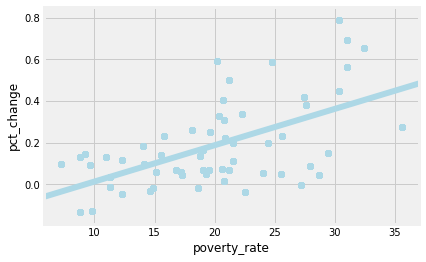

In [67]:
%matplotlib inline

import seaborn as sns

sns.regplot(x='poverty_rate', y='pct_change', ci=None, data=joined, color='lightblue')

<hr>

## 311 data regarding missed recyling collections

Data is <code>311_Service_Requests_from_2010_to_Present.csv</code>

I grabbed and filtered the data on NYC Open Data and filtered it to only include DSNY complaints mentioning recycling

In [180]:
df_311 = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', usecols=['Unique Key', 'Created Date', 'Agency', 'Agency Name', 'Complaint Type', 'Descriptor','Location Type', 'Incident Zip', 'Incident Address', 'Street Name', 'City', 'Resolution Description', 'Community Board', 'X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Latitude', 'Longitude', 'Borough'])
df_311['year'] = df_311['Created Date'].str.extract('\d+\/\d+\/(\d+)') ## this grabs the year

In [181]:
df_311.head(1)

,Unique Key,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,City,Resolution Description,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Latitude,Longitude,year
0,44916024,11/13/2019 10:19:00 AM,DSNY,BCC - Queens West,Missed Collection (All Materials),1R Missed Recycling-All Materials,Sidewalk,11378.0,59-15 69 LANE,69 LANE,Maspeth,The Department of Sanitation is in the process...,05 QUEENS,QUEENS,1014336.0,203004.0,40.723825,-73.891457,2019


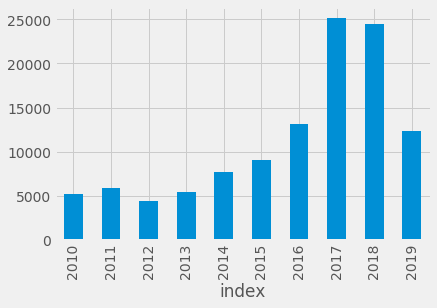

In [182]:
df_311.year.value_counts().reset_index().sort_values('index', ascending=True).plot(kind='bar', x='index', y='year', legend=False)

In [183]:
df_311['Community Board'].value_counts().head(10)

01 STATEN ISLAND    14443
03 STATEN ISLAND    13643
02 STATEN ISLAND     9859
01 BROOKLYN          5280
07 QUEENS            4791
12 BROOKLYN          3307
13 QUEENS            3241
03 BROOKLYN          2706
08 QUEENS            2661
12 QUEENS            2604
Name: Community Board, dtype: int64

In [186]:
df_311['Borough'].value_counts().head(6)

STATEN ISLAND    37952
BROOKLYN         32470
QUEENS           27294
MANHATTAN         8435
BRONX             6690
Unspecified          8
Name: Borough, dtype: int64

#Different Drop off locations

In [39]:
textile=pd.read_csv('Textile_Drop-Off_Locations_in_NYC.csv')
textile

,Address,BBL,BIN,BoroCD,Borough,CT2010,CouncilDistrict,Items_Accepted,Latitude,Longitude,...,Unit,Vendor_Name,Website,point,zipcode,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,606 E 89 St,3079930000,3224082,318,Brooklyn,964,46,"Clothing, Shoes, Accessories, Coats, Bedding A...",40.64240,-73.90993,...,NaN,Christian Church Of Canarsie,https://www1.nyc.gov/assets/donate/giveandfind...,POINT (-73.909932 40.642403),11236,13827,5.0,2.0,8.0,42.0
1,1133 Ogden Ave,2025260000,2088158,204,Bronx,199,16,"Clothing, Shoes",40.83659,-73.92780,...,NaN,Usagain LLC,http://www.usagain.com/,POINT (-73.927801 40.836595),10452,10930,50.0,5.0,42.0,27.0
2,10 Cebra Ave,5001150000,5002741,501,Staten Island,75,49,"Clothing, Shoes",40.63412,-74.08648,...,NaN,Planet Aid,http://www.planetaid.org/,POINT (-74.086477 40.63412199999999),10301,10369,4.0,1.0,13.0,74.0
3,1169 Bay St,5028290000,5107418,501,Staten Island,6,49,"Clothing, Shoes, Accessories",40.61481,-74.06644,...,NaN,Community Recycling LLC,https://www.communityrecycling.biz/,POINT (-74.066443 40.614809),10305,10692,4.0,1.0,13.0,74.0
4,137-42 Guy R Brewer Blvd,4123090000,4266757,412,Queens,294,28,"Clothing, Shoes, Accessories, Bedding and line...",40.67093,-73.77412,...,NaN,Helpsy,https://www.helpsy.co/,POINT (-73.774124 40.670926),11434,24669,41.0,3.0,46.0,71.0
5,4844 Hylan Blvd,5063980000,5082010,503,Staten Island,176,51,"Clothing, Shoes, Coats, Accessories, Bedding, ...",40.52655,-74.16738,...,NaN,American Recycling Technologies Inc.,http://www.americanrecyclingtech.com/,POINT (-74.167381 40.526554),10312,10699,15.0,1.0,9.0,77.0
6,611 Grand Concourse,2023480000,2001076,204,Bronx,63,8,"Clothing, Shoes, Accessories, Bedding and line...",40.82045,-73.92674,...,NaN,Helpsy,https://www.helpsy.co/,POINT (-73.926739 40.82045500000001),10451,10929,50.0,5.0,35.0,27.0
7,50-15 Roosevelt Ave,4013190000,4030851,402,Queens,25302,26,"Clothing, Shoes, Coats, Towels",40.74403,-73.91456,...,NaN,Carecycle Inc,carecyclecares.com/,POINT (-73.914562 40.74403),11377,14787,53.0,3.0,33.0,66.0
8,77-00 Queens Blvd,4024520000,4056456,404,Queens,479,25,"Clothing, Shoes, Accessories",40.73808,-73.88610,...,NaN,Community Recycling LLC,https://www.communityrecycling.biz/,POINT (-73.886102 40.738083),11373,14784,66.0,3.0,5.0,68.0
9,1809 Utica Ave,3077980000,3216426,318,Brooklyn,730,46,"Clothing, Shoes, Accessories, Bedding and line...",40.62799,-73.92747,...,NaN,Helpsy,https://www.helpsy.co/,POINT (-73.927472 40.62798999999998),11234,13825,5.0,2.0,8.0,38.0


In [65]:
bins=textile.BoroCD.value_counts().reset_index()
bins = bins.rename(columns={'index': 'BoroCD','BoroCD':'No.BoroCD'})
bins.head(3)

,BoroCD,No.BoroCD
0,501,59
1,412,57
2,318,43


In [91]:
borou=textile.Borough.value_counts().reset_index()
borou = borou.rename(columns={'index': 'Borough','Borough':'No_Borough'})
borou.head(5)

,Borough,No_Borough
0,Brooklyn,325
1,Queens,293
2,Manhattan,206
3,Bronx,205
4,Staten Island,112


In [72]:
prc=pd.read_csv('10-year-change.csv')
prc = prc.rename(columns={'borough_code': 'BoroCD'})
prc.head(5)

,BoroCD,pct_recyc_2018,pct_recyc_2009,pct_change
0,101,0.457068,0.525482,-0.130192
1,102,0.405030,0.357676,0.132396
2,103,0.220118,0.209310,0.051639
3,104,0.372049,0.376665,-0.012255
4,105,0.346514,0.334442,0.036097


In [75]:
join=bins.merge(prc, on='BoroCD')
join.head(5)

,BoroCD,No.BoroCD,pct_recyc_2018,pct_recyc_2009,pct_change
0,501,59,0.251563,0.235038,0.070306
1,412,57,0.193020,0.165567,0.165812
2,318,43,0.211713,0.218775,-0.032279
3,209,43,0.141494,0.102497,0.380468
4,305,41,0.141763,0.135917,0.043010


In [ ]:
secondjoin=join.merge(borou,on)

In [82]:
join.to_csv('bin-and-pct.csv')

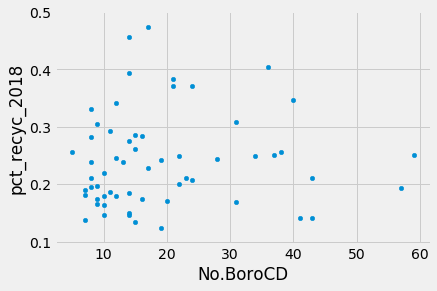

In [81]:
fig=join.plot(kind='scatter',x='No.BoroCD',y='pct_recyc_2018')